# Modeling - First Pass

### Installs, Packages, Seeds

In [17]:
# %pip install mobilenet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
ERROR: Could not find a version that satisfies the requirement mobilenet (from versions: none)
ERROR: No matching distribution found for mobilenet
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch
# %pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# other
import importlib

In [42]:
import build_model2
importlib.reload(build_model2)

from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Grid Components

In [3]:
# epoch_search = [50]
# # optim_search = ['SGD']
# model_search = ['resnet', 'vgg']
# lr_search = [.003, .0035]
# split_search = ['split_8', 'split_9', 'split_10']

# prods = list(product(epoch_search, model_search, lr_search, split_search))

# es = pd.Series(list(zip(*prods))[0], name = 'epochs', dtype = 'int')
# mods = pd.Series(list(zip(*prods))[1], name = 'pretrained_model')
# learns = pd.Series(list(zip(*prods))[2], name = 'learning_rate')
# splits = pd.Series(list(zip(*prods))[3], name = 'data_split')

# g_search = pd.concat([es, mods, learns, splits], axis = 1)

Load custom grid

In [4]:
# custom_grid = pd.read_csv('/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/gridsearch5/custom_grid.csv')
# g_search = custom_grid
# g_search

In [5]:
# g_search.index+=500 # index to add to prior run

## Parameters

In [43]:
model_dict = {'pretrained_model': 'resnet', 
              'epochs': 1, # NEEDS UPDATE
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/mobilenet',
              'csv_name': 'full_data_final_diverse',
              'split': 'split_8',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .0035,                  # from prior gridsearch
              'batch_size':64,
              'num_workers':24,
              'transform':3,
              'results_file':'gridsearch_results',
              'model':None, # NEEDS UPDATE
              'device': torch.device('cuda:0'), # NEEDS UPDATE
              'optimizer': None, # NEEDS UPDATE
              'criterion': None, # NEEDS UPDATE
              'tuned_model_name': None, # NEEDS UPDATE
              'show_val_cm': False,
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

HOME = model_dict['home_directory']

GPU Type: Tesla T4
GPU Count: 1


In [44]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


## Data

## In for loop

In [48]:
# # Gridsearch

# # for i in g_search.iterrows():

# # extract gridsearch features
# # model_dict['epochs'] = i[1]['epochs']
# # model_dict['pretrained_model'] = i[1]['pretrained_model']
# model_dict['optimizer_name'] = 'SGD'
# # model_dict['lr'] = i[1]['learning_rate']
# # model_dict['split'] = i[1]['data_split']
# # me = i[1]['epochs']
# # mn = i[1]['pretrained_model']
# # mo = model_dict['optimizer_name']
# # ms = model_dict['split']
# # mlr = i[1]['learning_rate']
# # model_dict['alias'] = i[0]
# model_dict['tuned_model_name'] = f'mobilenet'
# direc = model_dict['mod_directory']
# nam = model_dict['tuned_model_name']
# # print(f'Learning Rate: {mlr}')

# # data for each split
# data, train, test, 
= load_split_data(directory = model_dict['home_directory'],
#                                          csv_name = model_dict['csv_name'], 
#                                          data_split = model_dict['split'], 
#                                          label = model_dict['cl'],
#                                          mode = 'all',
#                                          dev_state = model_dict['dev_state'], 
#                                          dev_sample = model_dict['dev_sample'], 
#                                          seed = model_dict['seed']
#                                          )

# # Label dictionary for evaluation
# labels_idx = np.sort(data.label_idx.unique())
# label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
# label_dict = dict(zip(label_map.label_idx, label_map['label']))
# model_dict['label_dict'] = label_dict

# # set batch size
# if model_dict['pretrained_model'] == 'efficientnet':
#     model_dict['batch_size'] = 3
# else: 
#     model_dict['batch_size'] = 64

# # Load each model
# model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
#                                         num_classes = len(data.label.unique()),
#                                         feature_extract = False, 
#                                         use_pretrained=True)

# # Move model to GPU
# model = model_ft.to(model_dict['device'])

# model_dict.update({
#                    'model':model,
#                    'criterion': nn.CrossEntropyLoss().to(model_dict['device']),
# })

# # Define optimizer options:
# if model_dict['optimizer_name'] == 'SGD':
#     model_dict.update({'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr'])})
# elif model_dict['optimizer_name'] == 'Adam':
#     model_dict.update({'optimizer': optim.Adam(model.parameters(), lr=model_dict['lr'])})
# elif model_dict['optimizer_name'] == 'AdamW':
#     model_dict.update({'optimizer': optim.AdamW(model.parameters(), lr=model_dict['lr'])})

# # Update dictionary
model_dict['resize'] = int(input_size/.85)


# Set Transforms
transform_header = [
                    transforms.Resize(model_dict['resize']), #255
                    transforms.CenterCrop(input_size)
                    ]

transform_body = [
                  transforms.RandomHorizontalFlip(), # a
                  transforms.RandomVerticalFlip(), # b
                  transforms.RandomRotation(20), # c
                  transforms.RandomCrop(size=(input_size,input_size)), # d
#                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
#                       transforms.RandomAdjustSharpness(sharpness_factor=2), # f
#                       transforms.RandomSolarize(threshold=192.0), # g
#                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                  ]

transform_footer = [transforms.ToTensor(), 
                  transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]

val_transform = transforms.Compose([
                                  transforms.Resize(model_dict['resize']),
                                  transforms.CenterCrop(input_size),
                                  transforms.ToTensor(), 
                                  transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                ])

test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])   

transform_list = transform_header + transform_body + transform_footer
train_transform = transforms.Compose(transform_list)
train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])


loaders = {'train_loader':train_loader,
                        'val_loader': val_loader,
                        'test_loader': test_loader}
model_dict['loader'] = loaders

# pred_df, val_scores, tot_time = train_model(model_dict = model_dict)

# acc, f1, f2, f5, prec, rec, d_0, d_1, d_2, d_3, d_4 = val_scores


# pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')

# col_dict = {
# #              'model': pd.Series(dtype = 'int'),
# #              'file': pd.Series(dtype = 'str'),
#          'tuned_model': model_dict['tuned_model_name'],
#          'transform': model_dict['transform'],
#          'lr': model_dict['lr'],
#          'pretrained_model': model_dict['pretrained_model'],
#          'optimizer': model_dict['optimizer_name'],
#          'epochs': model_dict['epochs'],
# #              'num_classes': model_dict['num_classes'],
#          'batch_size': model_dict['batch_size'],
#          'workers': model_dict['num_workers'],
#          'train_time': tot_time,
#          'data_split': model_dict['split'],
#          'label_set': model_dict['cl'],
#          'accur': acc,
#          'F1': f1,
#          'F0.5': f5,
#          'F2': f2,
#          'benign_accur': d_0,
#          'noncancerous_accur': d_1,
#          'malignant_accur': d_2,
#          'infection_accur': d_3,
#          'unclassified_accur': d_4
# }

# #     print(tdf.iloc[:i[0]+1][['transform', 'lr', 'accur']])
# add_results(model_dict['results_file'], direc, pd.DataFrame(col_dict, index = [510]))
# print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

In [49]:
model_dict['split'] = 'split_8'
model_dict['split']
model_dict

{'pretrained_model': 'resnet',
 'epochs': 1,
 'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
 'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/mobilenet',
 'csv_name': 'full_data_final_diverse',
 'split': 'split_8',
 'cl': 'label_0',
 'dev_state': False,
 'dev_sample': 15000,
 'seed': 99,
 'lr': 0.0035,
 'batch_size': 64,
 'num_workers': 24,
 'transform': 3,
 'results_file': 'gridsearch_results',
 'model': None,
 'device': device(type='cuda', index=0),
 'optimizer': None,
 'criterion': None,
 'tuned_model_name': None,
 'show_val_cm': False,
 'resize': 263,
 'loader': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7ff9381527f0>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x7ff938152310>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7ff938152250>}}

In [87]:
# model_dict['model'] =torch.load(f'model/gridsearch4/vgg_50e_SGD_split_10_GS220.pt')

device(type='cuda', index=0)

In [50]:
# # # 
pred_df = evaluate(model_name = 'gridsearch4/vgg_50e_SGD_split_10_GS220', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

TypeError: 'NoneType' object is not callable

In [28]:
new = pd.read_csv('full_data_final_diverse.csv', index_col = 0)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [104]:
test_trial = new[new.split_10 == 'test']

In [69]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'], csv_name = 'full_data_final_diverse', data_split = 'split_8', label = 'label_0', mode = 'all', dev_state = False, dev_sample = 15000, seed = 99)

/tmp/ipykernel_43577/2821554051.py:1: DtypeWarning: Columns (7,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'], csv_name = 'full_data_final_diverse', data_split = 'split_8', label = 'label_0', mode = 'all', dev_state = False, dev_sample = 15000, seed = 99)


In [106]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'], csv_name = 'full_data_final_diverse', data_split = 'split_8', label = 'label_0', mode = 'all', dev_state = False, dev_sample = 15000, seed = 99)
test_trial = test[['path', 'label_idx']]
loader = build_loader(mode = 'test', df = test_trial, transform = val_transform, batch_size = 64, num_workers = 24)

In [105]:
test_trial

,image_id,diagnosis,age,sex,localization,source,severity,unaltered_path,F6_path,path,...,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8,split_9,split_10
11,lichen-planus-84,psoriasis pictures lichen planus and related d...,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Nail Fungus and other Nai...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/dermnet/train/Nail Fungus and other Nai...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,train,test
14,lichen-planus-97,psoriasis pictures lichen planus and related d...,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Nail Fungus and other Nai...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/dermnet/train/Nail Fungus and other Nai...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,train,test
19,lichen-planus-125,psoriasis pictures lichen planus and related d...,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/test/Nail Fungus and other Nail...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/dermnet/test/Nail Fungus and other Nail...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,val,test,test
25,lichen-planus-144,psoriasis pictures lichen planus and related d...,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Nail Fungus and other Nai...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,train,test
26,lichen-planus-153,psoriasis pictures lichen planus and related d...,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/test/Nail Fungus and other Nail...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,test,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78117,ISIC_0073030,squamous-cell-carcinoma,55.0,female,anterior torso,ISIC_2019,NaN,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,train,test
78123,ISIC_0073037,basal cell carcinoma,85.0,male,anterior torso,ISIC_2019,NaN,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,train,test
78170,ISIC_0073113,basal cell carcinoma,25.0,female,head/neck,ISIC_2019,NaN,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,val,train,test
78175,ISIC_0073123,basal cell carcinoma,80.0,male,anterior torso,ISIC_2019,NaN,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,/home/ec2-user/SageMaker/teledermatologyAI_cap...,./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


In [107]:
model = torch.load(f'model/gridsearch4/vgg_50e_SGD_split_10_GS220.pt')
mode = 'test'
loader = loader
criterion = nn.CrossEntropyLoss().to(device)
# optimizer
# run(mode, loader, model, criterion, optimizer = None, epoch = None, model_dict = model_dict)
# evaluate(model_name = 'gridsearch4/vgg_50e_SGD_split_10_GS220', 
#                    model_source = 'pt', 
#                    model_dict = model_dict, 
#                    label_dict = label_dict, 
#                    show_cm = True)

In [108]:
model_dict['split'] = 'split_10'
model_dict['split']

'split_10'

In [109]:
model_dict['loader']['test_loader'] = loader
model_dict['loader']['test_loader']

In [110]:
 model_dict.update({
                   'criterion': nn.CrossEntropyLoss().to(model_dict['device']),
})
model_dict['criterion']

CrossEntropyLoss()

In [111]:
loader

In [115]:
label_dict

{0: 'Benign Marking or Mole',
 1: 'Non-Cancerous Skin Condition',
 2: 'Potentially Malignant Skin Tumors',
 3: 'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
 4: 'Unclassified'}

------------------------------------------------------------
[epoch test], [test loss 1.43232], [test acc 0.66750]
------------------------------------------------------------


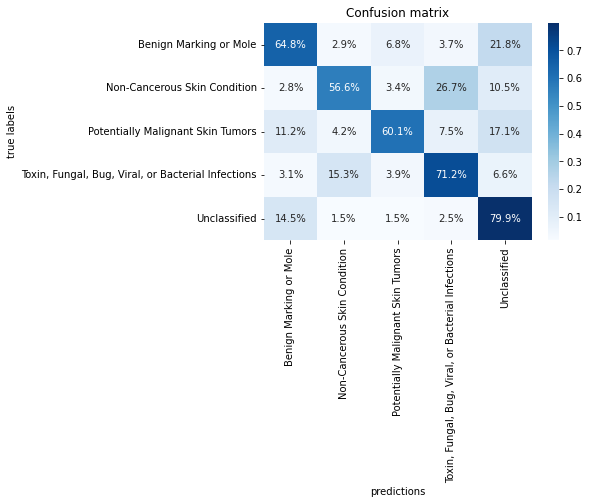

In [114]:
pred_df = evaluate(model_name = 'gridsearch4/resnet_50e_SGD_split_8_GS212', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.89213], [test acc 0.71148]
------------------------------------------------------------


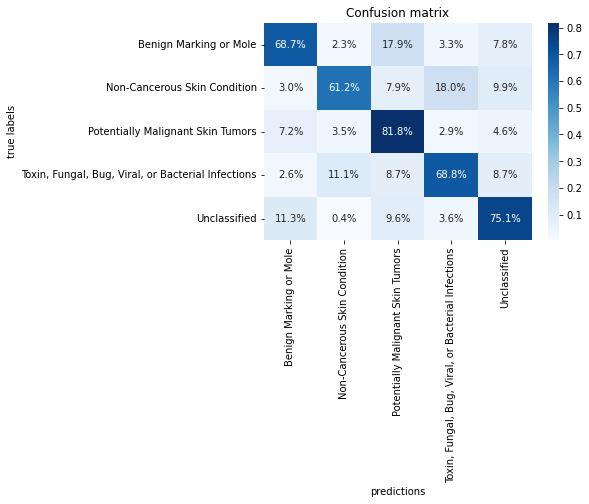

In [112]:
pred_df = evaluate(model_name = 'gridsearch4/vgg_50e_SGD_split_10_GS220', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

In [113]:
pred_df

,lab,pred,lab_idx,pred_idx
0,Non-Cancerous Skin Condition,Unclassified,1,4
1,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,1,1
2,Non-Cancerous Skin Condition,Unclassified,1,4
3,Non-Cancerous Skin Condition,"Toxin, Fungal, Bug, Viral, or Bacterial Infect...",1,3
4,"Toxin, Fungal, Bug, Viral, or Bacterial Infect...","Toxin, Fungal, Bug, Viral, or Bacterial Infect...",3,3
...,...,...,...,...
2413,Potentially Malignant Skin Tumors,Potentially Malignant Skin Tumors,2,2
2414,Potentially Malignant Skin Tumors,Potentially Malignant Skin Tumors,2,2
2415,Benign Marking or Mole,Benign Marking or Mole,0,0
2416,Potentially Malignant Skin Tumors,Potentially Malignant Skin Tumors,2,2


In [81]:
from build_model2 import run

In [58]:
model = torch.load(f'model/gridsearch4/vgg_50e_SGD_split_10_GS220.pt')